In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [2]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [3]:
fname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_final'}.xlsx")
cname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_case'}.xlsx")
lname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_law'}.xlsx")

dff = pd.read_excel(fname, index_col=0)
dfc = pd.read_excel(cname, index_col=0)
dfl = pd.read_excel(lname, index_col=0)

df = pd.concat([dff[['text', 'y_appeal']], dfc[1:], dfl[1:]], axis=1).reindex(dff.index)
df = df.dropna(subset=['y_appeal'])

In [4]:
df_0 = df[df['y_appeal'] == 0].sample(frac=1)
df_1 = df[df['y_appeal'] == 1].sample(frac=1)

sample_size = len(df_0) if len(df_0) < len(df_1) else len(df_1)

df = pd.concat([df_0.head(sample_size), df_1.head(sample_size)]).sample(frac=1)

In [5]:
X = df.drop('y_appeal', axis=1)
y = tf.keras.utils.to_categorical(df['y_appeal'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
X1_train = X_train[dfc.columns[1:]]
X1_test = X_test[dfc.columns[1:]]

X2_train = X_train[dfl.columns[1:]]
X2_test = X_test[dfl.columns[1:]]

In [8]:
X3_train = list(X_train["text"])
X3_test = list(X_test["text"])

max_features = 30000
sequence_length = 256

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(X3_train)

X3_train = tokenizer.texts_to_sequences(X3_train)
X3_test = tokenizer.texts_to_sequences(X3_test)

X3_train = tf.keras.preprocessing.sequence.pad_sequences(X3_train, sequence_length)
X3_test = tf.keras.preprocessing.sequence.pad_sequences(X3_test, sequence_length)

In [9]:
input_1 = tf.keras.Input(dtype = tf.float32, shape = (len(dfc.columns[1:]),))
input_2 = tf.keras.Input(dtype = tf.float32, shape = (len(dfl.columns[1:]),))

dense_layer_1_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_1)
dense_layer_1_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_1)
dense_layer_1_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_2)
dense_layer_1_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_3)
dropout_1_5 = tf.keras.layers.Dropout(rate = 0.5)(dense_layer_1_4)


dense_layer_2_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_2)
dense_layer_2_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_1)
dense_layer_2_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_2)
dense_layer_2_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_3)
dropout_2_5 = tf.keras.layers.Dropout(rate = 0.5)(dense_layer_2_4)

In [10]:
embeddings_index = {}
f = open(os.path.join(os.path.dirname(os.getcwd()), 'data_processing', 'ft_0825_6.txt'),  encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

word_index = tokenizer.word_index

num_words = min(max_features, len(word_index)) + 1
print(num_words)
embedding_dim = 200
num_filters = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

13510


In [11]:
input_3 = tf.keras.Input(dtype = tf.float32, shape = (sequence_length,))
embedding_layer_3 = tf.keras.layers.Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(input_3)

reshape_3 = tf.keras.layers.Reshape((sequence_length, embedding_dim, 1))(embedding_layer_3)

conv_0_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, embedding_dim), activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_1_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(4, embedding_dim), activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_2_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(5, embedding_dim), activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)

maxpool_0_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_3)
maxpool_1_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_3)
maxpool_2_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_3)

concatenated_tensor_3 = tf.keras.layers.Concatenate(axis=1)([maxpool_0_3, maxpool_1_3, maxpool_2_3])
flatten_3 = tf.keras.layers.Flatten()(concatenated_tensor_3)
dropout_3 = tf.keras.layers.Dropout(rate = 0.5)(flatten_3)

In [12]:
concat_layer = tf.keras.layers.Concatenate()([dropout_1_5, dropout_2_5, dropout_3])

dense_layer_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(concat_layer)
dense_layer_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_3)
dense_layer_5 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4)
dense_layer_6 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_5)


output = tf.keras.layers.Dense(units = 2, activation = tf.nn.softmax)(dense_layer_4)

model = tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=output)

In [13]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), metrics=['acc'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 200)     2702000     input_3[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 153)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 567)]        0                                            
______________________________________________________________________________________________

In [14]:
history = model.fit(x=[X1_train, X2_train, X3_train], y=y_train, batch_size=2, epochs=80, verbose=1, validation_split=0.1)

Train on 864 samples, validate on 97 samples
Epoch 1/80
864/864 [==============================] - 4s 5ms/sample - loss: 14.6570 - acc: 0.5174 - val_loss: 11.2907 - val_acc: 0.4536
Epoch 2/80
864/864 [==============================] - 2s 2ms/sample - loss: 8.9781 - acc: 0.5347 - val_loss: 6.9952 - val_acc: 0.6495
Epoch 3/80
864/864 [==============================] - 2s 2ms/sample - loss: 5.6169 - acc: 0.5648 - val_loss: 4.4523 - val_acc: 0.6804
Epoch 4/80
864/864 [==============================] - 2s 2ms/sample - loss: 3.6263 - acc: 0.5775 - val_loss: 2.9367 - val_acc: 0.7113
Epoch 5/80
864/864 [==============================] - 2s 2ms/sample - loss: 2.4366 - acc: 0.6157 - val_loss: 2.0258 - val_acc: 0.6804
Epoch 6/80
864/864 [==============================] - 2s 2ms/sample - loss: 1.7149 - acc: 0.6250 - val_loss: 1.4728 - val_acc: 0.4845
Epoch 7/80
864/864 [==============================] - 2s 2ms/sample - loss: 1.2731 - acc: 0.6389 - val_loss: 1.1240 - val_acc: 0.6907
Epoch 8/80
864/

864/864 [==============================] - 2s 2ms/sample - loss: 0.3722 - acc: 0.9722 - val_loss: 0.4563 - val_acc: 0.8969
Epoch 62/80
864/864 [==============================] - 2s 2ms/sample - loss: 0.3773 - acc: 0.9618 - val_loss: 0.4523 - val_acc: 0.8969
Epoch 63/80
864/864 [==============================] - 2s 2ms/sample - loss: 0.3698 - acc: 0.9653 - val_loss: 0.4781 - val_acc: 0.8454
Epoch 64/80
864/864 [==============================] - 2s 2ms/sample - loss: 0.3789 - acc: 0.9572 - val_loss: 0.4646 - val_acc: 0.8454
Epoch 65/80
864/864 [==============================] - 2s 2ms/sample - loss: 0.3943 - acc: 0.9525 - val_loss: 0.4933 - val_acc: 0.8557
Epoch 66/80
864/864 [==============================] - 2s 2ms/sample - loss: 0.3672 - acc: 0.9745 - val_loss: 0.4769 - val_acc: 0.8351
Epoch 67/80
864/864 [==============================] - 2s 2ms/sample - loss: 0.3679 - acc: 0.9653 - val_loss: 0.4589 - val_acc: 0.8866
Epoch 68/80
864/864 [==============================] - 2s 2ms/sampl

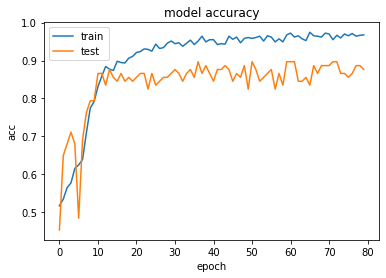

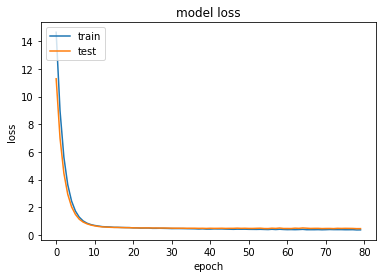

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [16]:
score = model.evaluate(x=[X1_test, X2_test, X3_test], y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test ACC:", score[1])

107/107 [==============================] - 0s 4ms/sample - loss: 0.4850 - acc: 0.9159
Test Score: 0.48496241407973745
Test ACC: 0.91588783
